In [1]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.optimize import curve_fit
import pandas as pd
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


In [ ]:
# 打开 ROOT 文件，载入 events tree
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
#Energy_Train=(0.5,)
Energy_Val=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,40.0,60.0)
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    #MCP_px = tree["MCParticles.momentum.x"].array(library="np")
    #MCP_py = tree["MCParticles.momentum.y"].array(library="np")
    #MCP_pz = tree["MCParticles.momentum.z"].array(library="np")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    #print to check
    # sorted_indices = np.argsort(calo_layer[0])
    # energy_sorted = energy[0][sorted_indices].to_numpy()
    # layer_sorted = calo_layer[0][sorted_indices].to_numpy()
    # posz_sorted = pos_z[0][sorted_indices].to_numpy()
    # print("Event 0 (sorted by layer):")
    # for l, e, z in zip(layer_sorted, energy_sorted, posz_sorted):
    #     print(f"  Layer {l:2d} | Energy = {e:.5f} | PosZ = {z:.5f }")

    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)

    #print("Event 0:")
    #for layer_idx, (E_val, N_val) in enumerate(zip(E_layers_all[0], N_layers_all[0])):
    #    print(f"  Layer {layer_idx:2d} | E_layer = {E_val:.5f} | N_layer = {N_val}")
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_validate, N_layers_validate, E_truth_validate = ReadData_Energy(DataPath_Validate,Energy_Val)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/3.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/4.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/6.5GeV.root

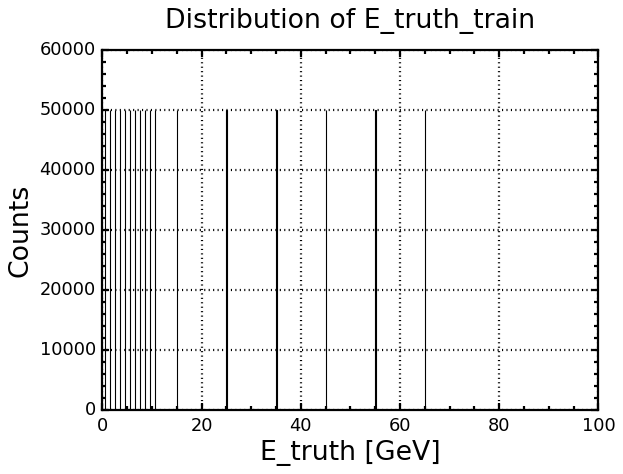

In [14]:
#Read Data
plt.figure(figsize=fig_size)
plt.hist(E_truth_train, bins=1000, range=(0, 100), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.xlim(0, 100)
plt.ylabel("Counts")
plt.title("Distribution of E_truth_train")
plt.grid(True)
plt.show()

In [15]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    print("shape", E_layers.shape, N_layers.shape, E_truth.shape)
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_validate, N_layers_validate, E_sum_val, N_sum_val, E_truth_validate = Event_Selection(E_layers_validate, N_layers_validate, E_truth_validate)

shape (850000, 30) (850000, 30) (850000,)
shape (1250000, 30) (1250000, 30) (1250000,)
shape (50000, 30) (50000, 30) (50000,)


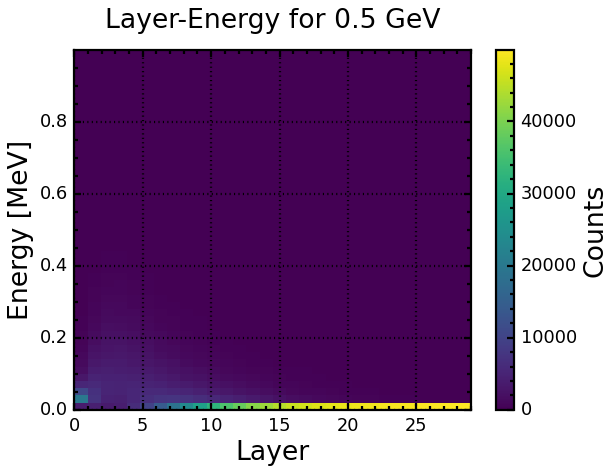

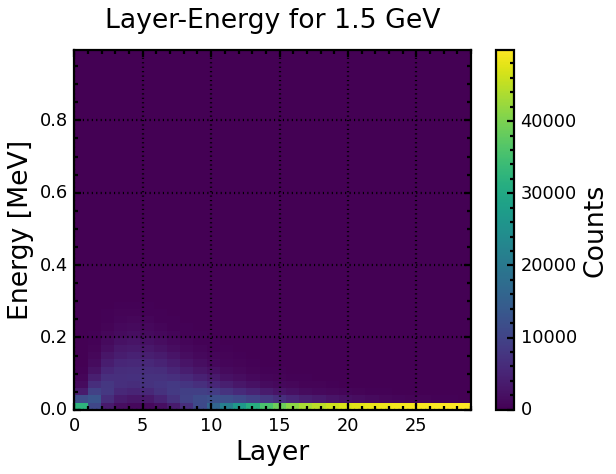

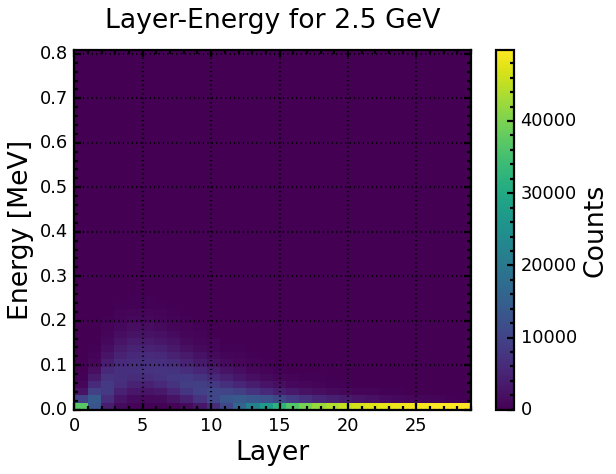

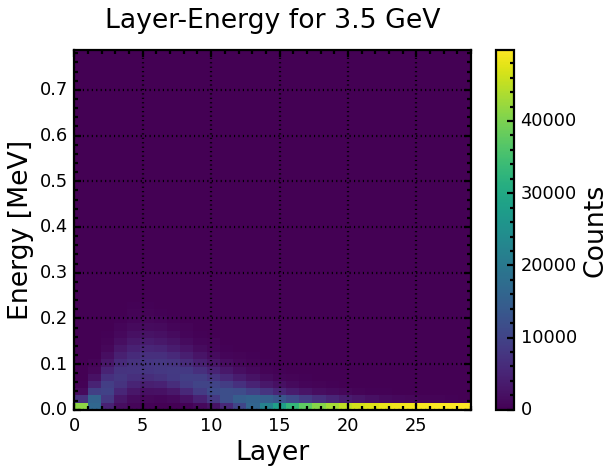

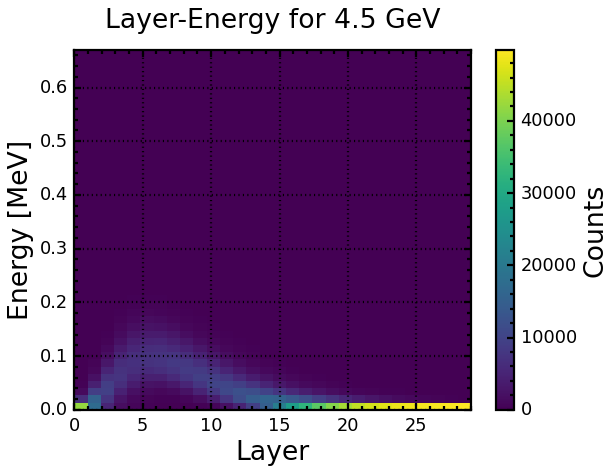

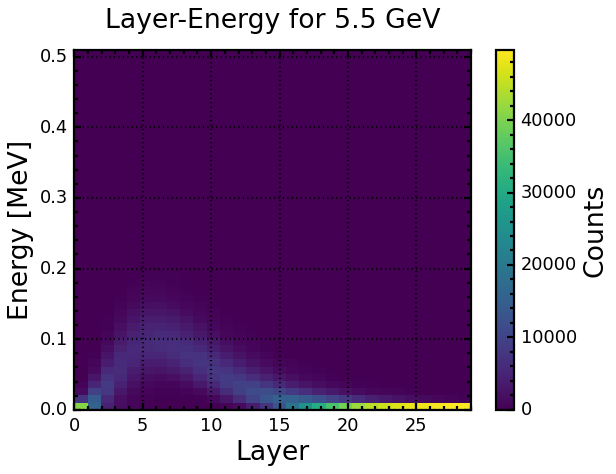

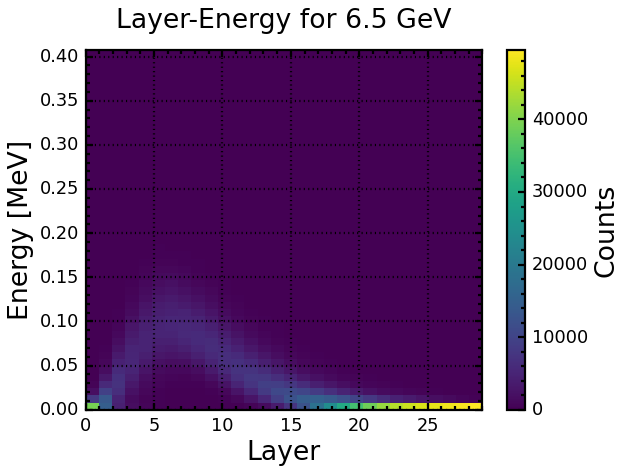

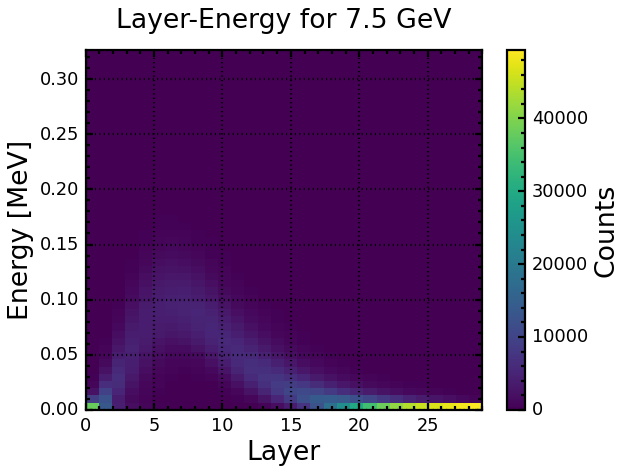

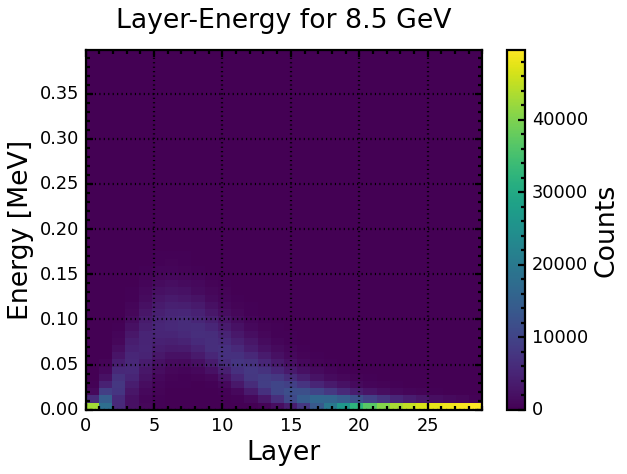

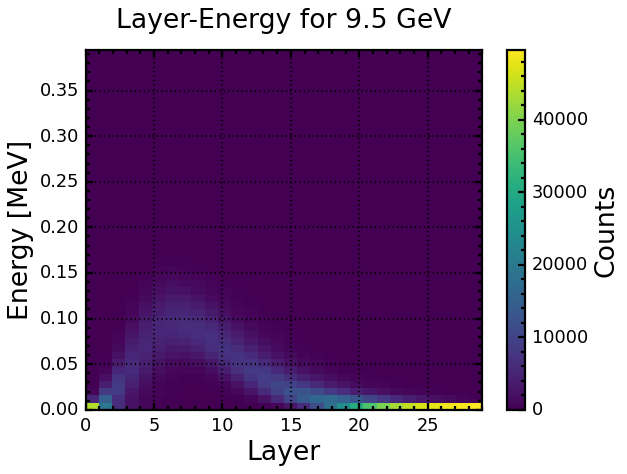

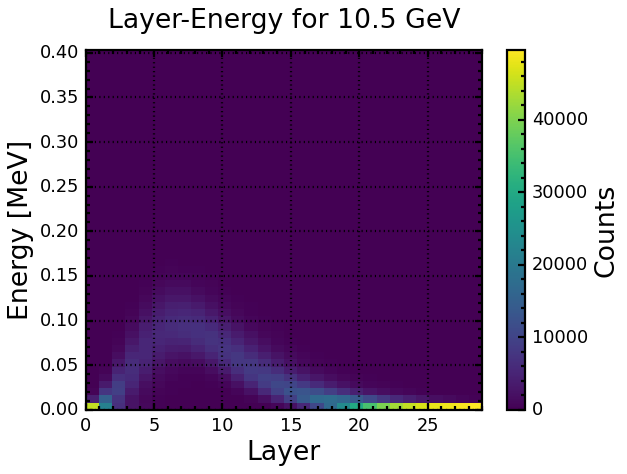

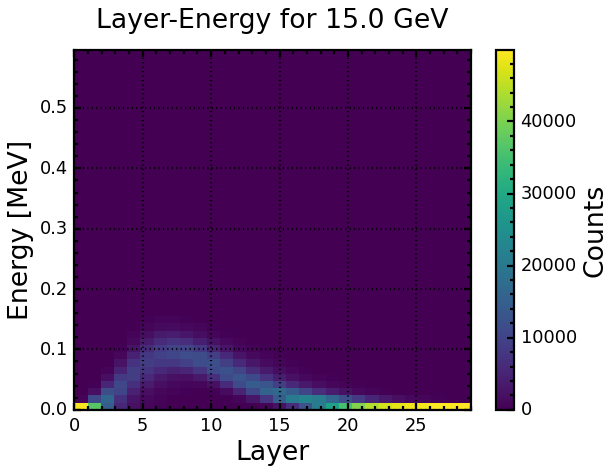

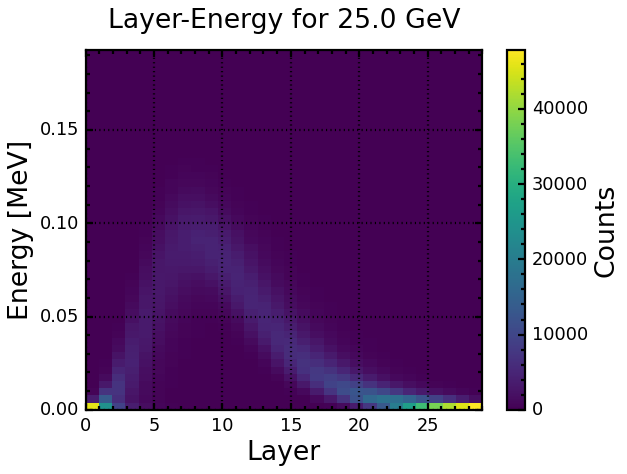

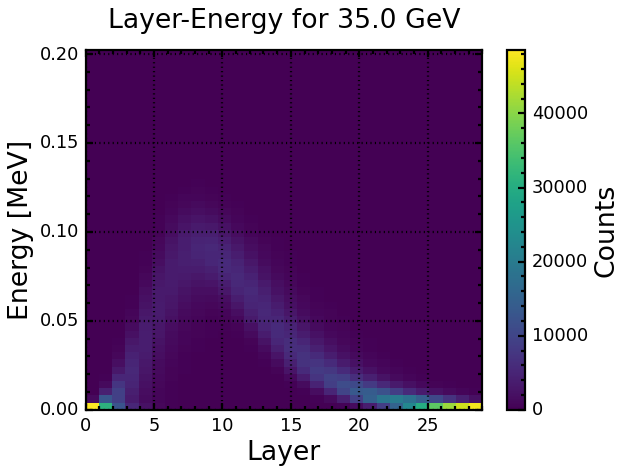

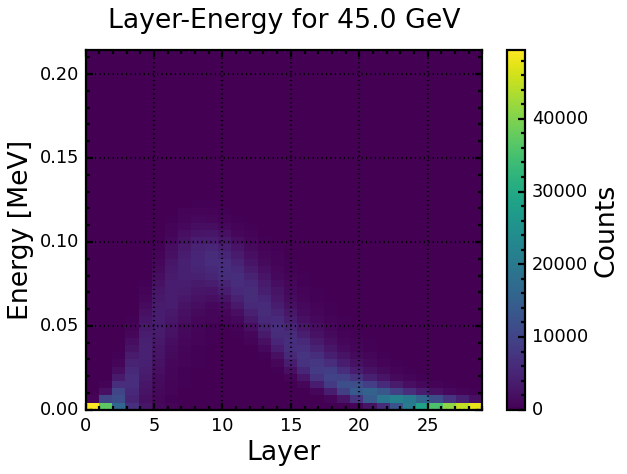

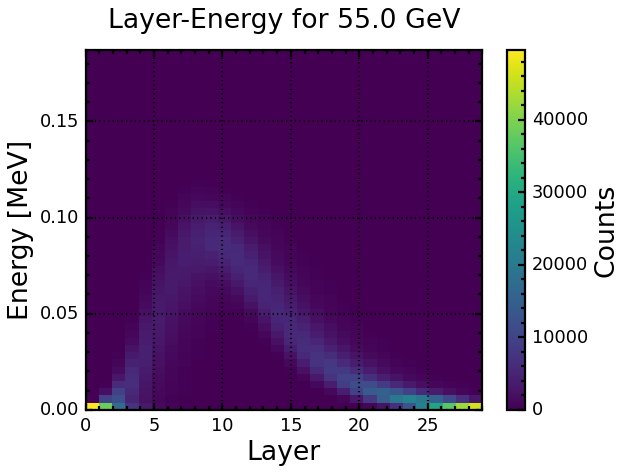

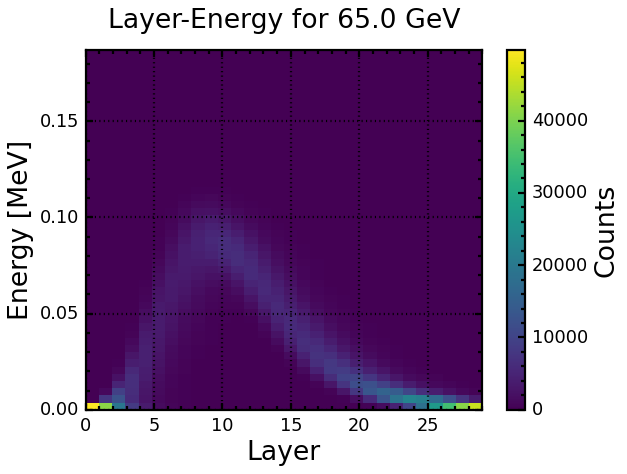

In [16]:
#2D hist Layer-Energy
for i_E, E_truth in enumerate(Energy_Train):
    mask = (E_truth_train == E_truth)
    E_layers = E_layers_train[mask]
    E_sum = np.sum(E_layers, axis=1) + 1e-6
    data = np.array(E_layers_train[mask]/E_sum[:, None])  # shape: (N, 30) 

    x = np.arange(data.shape[1])           # [0, 1, ..., 29]
    X = np.tile(x, data.shape[0])          # 展开 index
    Y = data.flatten()                     # 展开 values    

    plt.figure(figsize=(8,6))
    plt.hist2d(X, Y, bins=(30, 50), cmap='viridis')  # 30 bins for index, 50 for value
    plt.colorbar(label="Counts")    

    plt.xlabel("Layer")
    plt.ylabel("Energy [MeV]")
    plt.title(f"Layer-Energy for {E_truth} GeV")
    plt.show()


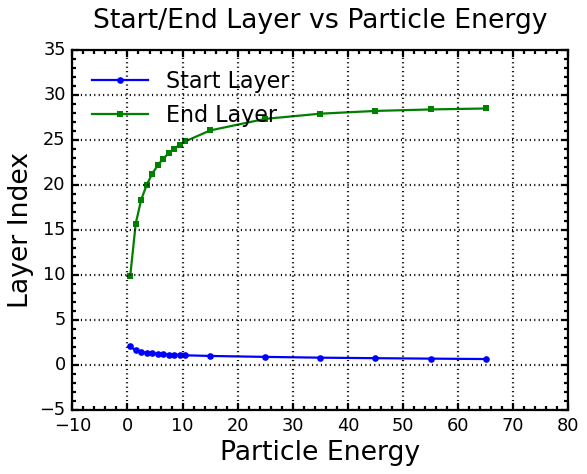

In [17]:
#Graph start/end layer
start_layers = []
end_layers = []

for i_E, E_truth in enumerate(Energy_Train):
    mask = (E_truth_train == E_truth)
    data = np.array(N_layers_train[mask])  # shape: (n_samples, n_layers)
    
    starts = []
    ends = []
    for row in data:
        # 找到所有 >1 的层索引
        idx = np.where(row > 1)[0]
        if len(idx) > 0:
            starts.append(idx[0])   # 第一个
            ends.append(idx[-1])    # 最后一个
    
    # 记录该能量下的平均 start/end
    start_layers.append(np.mean(starts) if starts else np.nan)
    end_layers.append(np.mean(ends) if ends else np.nan)

# 转换为 array
start_layers = np.array(start_layers)
end_layers = np.array(end_layers)

# 画图
plt.figure(figsize=(8,6))
plt.plot(Energy_Train, start_layers, marker='o', label="Start Layer")
plt.plot(Energy_Train, end_layers, marker='s', label="End Layer")

plt.xlabel("Particle Energy")
plt.ylabel("Layer Index")
plt.title("Start/End Layer vs Particle Energy")
plt.legend(loc='upper left')
plt.show()



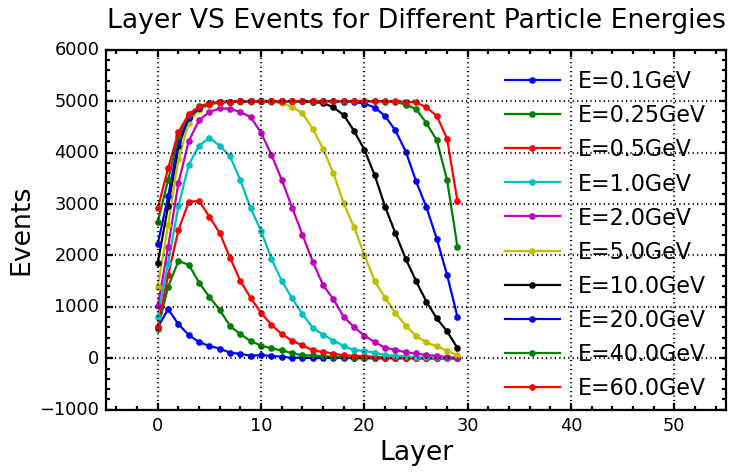

In [18]:
#2D hist layer counts
n_layers = N_layers_train.shape[1]

plt.figure(figsize=(10,6))

for E_truth in Energy_Val:
    mask = (E_truth_validate == E_truth)
    data = np.array(N_layers_validate[mask])   # (n_events, n_layers)

    # 每层 hit 的事例数
    counts = np.sum(data > 1, axis=0)

    plt.plot(np.arange(n_layers), counts, marker='o', label=f"E={E_truth}GeV")

plt.xlabel("Layer")
plt.xlim(-5,55)
plt.ylabel("Events")
plt.title("Layer VS Events for Different Particle Energies")
plt.legend()
plt.show()



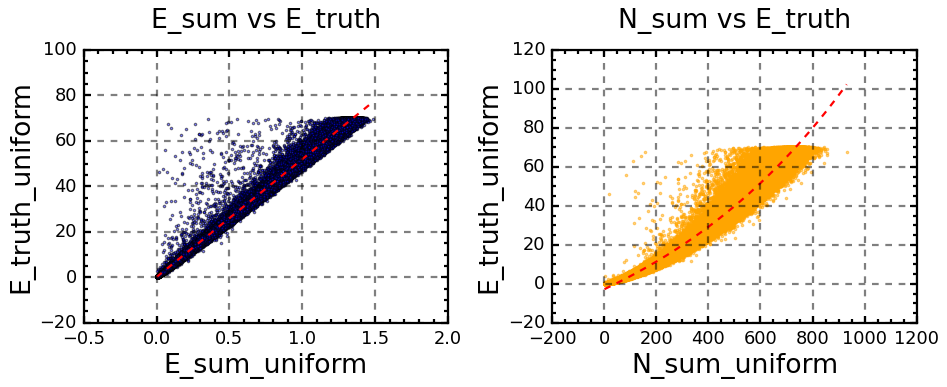

In [19]:
plt.figure(figsize=(12, 5))

coeffs_calibE = np.polyfit(E_sum_uniform, E_truth_uniform, 1)
E_fit_line = np.poly1d(coeffs_calibE)
plt.subplot(1, 2, 1)
plt.scatter(E_sum_uniform, E_truth_uniform, s=5, alpha=0.5)
x_line = np.linspace(min(E_sum_uniform), max(E_sum_uniform), 200)
plt.plot(x_line, E_fit_line(x_line), color="red", linestyle="--", label="Fit Line")
plt.xlabel("E_sum_uniform")
plt.ylabel("E_truth_uniform")
plt.title("E_sum vs E_truth")
plt.grid(True, linestyle="--", alpha=0.5)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform, E_truth_uniform, p0=(1, 0.01, 1))
plt.subplot(1, 2, 2)
plt.scatter(N_sum_uniform, E_truth_uniform, s=5, alpha=0.5, color="orange")
x_line_N = np.linspace(min(N_sum_uniform), max(N_sum_uniform), 200)
plt.plot(x_line_N, exp_func(x_line_N, *coeffs_calibN), color="red", linestyle="--", label="Fit Line")
plt.xlabel("N_sum_uniform")
plt.ylabel("E_truth_uniform")
plt.title("N_sum vs E_truth")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

E_sum_train_calib = E_fit_line(E_sum_train)
E_sum_uniform_calib = E_fit_line(E_sum_uniform)
E_sum_val_calib = E_fit_line(E_sum_val)
N_sum_train_calib = exp_func(N_sum_train, *coeffs_calibN)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
N_sum_val_calib = exp_func(N_sum_val, *coeffs_calibN)

Fitted params for a for layer 0: a=283458.9667, b=0.0000, c=-283457.9664
Fitted params for a for layer 1: a=73645.1561, b=0.0000, c=-73629.4008
Fitted params for a for layer 2: a=127230.6147, b=0.0000, c=-127213.4115
Fitted params for a for layer 3: a=100438.8433, b=0.0000, c=-100422.2861
Fit failed for a for layer 4
Fitted params for a for layer 5: a=145992.4444, b=0.0000, c=-145979.2040
Fitted params for a for layer 6: a=111897.8802, b=0.0000, c=-111886.2102
Fitted params for a for layer 7: a=117251.9161, b=0.0000, c=-117240.4635
Fitted params for a for layer 8: a=142360.7949, b=0.0000, c=-142350.0207
Fitted params for a for layer 9: a=199793.3501, b=0.0000, c=-199784.8951


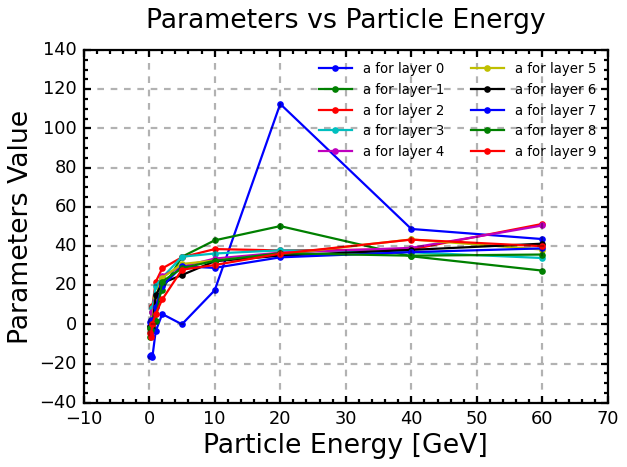

Fitted params for a for layer 10: a=130194.2889, b=0.0000, c=-130184.6164
Fitted params for a for layer 11: a=159090.6129, b=0.0000, c=-159082.9290
Fitted params for a for layer 12: a=96672.9919, b=0.0000, c=-96658.6460
Fitted params for a for layer 13: a=149838.1691, b=0.0000, c=-149833.0323
Fitted params for a for layer 14: a=144924.1697, b=0.0000, c=-144917.4324
Fit failed for a for layer 15
Fitted params for a for layer 16: a=158536.5748, b=0.0000, c=-158537.0890
Fitted params for a for layer 17: a=172165.5001, b=0.0000, c=-172164.0491
Fitted params for a for layer 18: a=141576.4405, b=0.0000, c=-141570.1630
Fitted params for a for layer 19: a=53242.2639, b=0.0000, c=-53229.6940


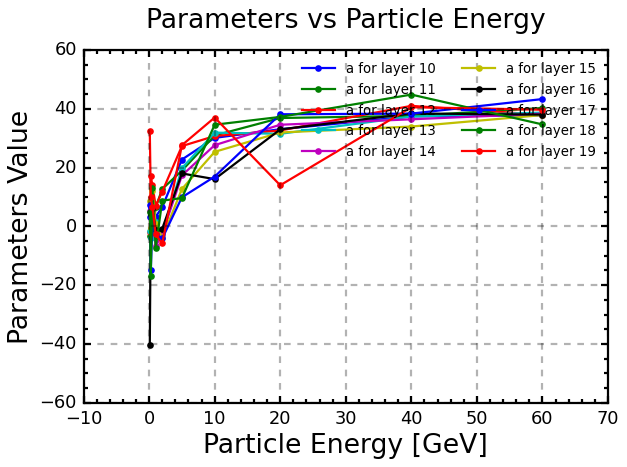

Fitted params for a for layer 20: a=140913.8099, b=0.0000, c=-140909.0706
Fitted params for a for layer 21: a=52786.3712, b=0.0000, c=-52781.6352
Fitted params for a for layer 22: a=135486.1892, b=0.0000, c=-135486.5841
Fitted params for a for layer 23: a=245242.8833, b=0.0000, c=-245245.1281
Fit failed for a for layer 24
Fitted params for a for layer 25: a=89.3837, b=0.0106, c=-74.6362
Fitted params for a for layer 26: a=339079.0021, b=0.0000, c=-339108.4802
Fitted params for a for layer 27: a=228194.4295, b=0.0000, c=-228210.1056
Fitted params for a for layer 28: a=140340.3947, b=0.0000, c=-140352.7285
Fit failed for a for layer 29


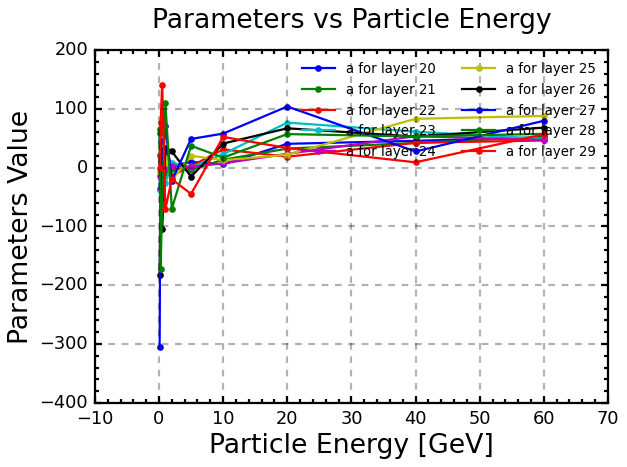

Fitted params for b for layer 0: a=-104.7099, b=0.0000, c=104.7885
Fitted params for b for layer 1: a=-44.7323, b=0.0000, c=44.7563
Fitted params for b for layer 2: a=11.9132, b=-0.0000, c=-11.8985
Fitted params for b for layer 3: a=-11.0563, b=0.0000, c=11.0696
Fitted params for b for layer 4: a=64.7963, b=-0.0000, c=-64.7783
Fitted params for b for layer 5: a=-20.1376, b=0.0000, c=20.1546
Fitted params for b for layer 6: a=9.2736, b=-0.0000, c=-9.2557
Fitted params for b for layer 7: a=1.3481, b=-0.0000, c=-1.3308
Fitted params for b for layer 8: a=16.0261, b=0.0000, c=-16.0088
Fitted params for b for layer 9: a=1.0466, b=-0.0000, c=-1.0276


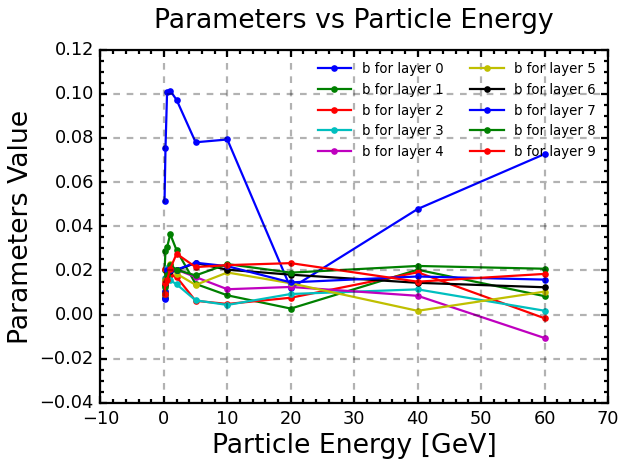

Fitted params for b for layer 10: a=27.7340, b=0.0000, c=-27.7175
Fitted params for b for layer 11: a=37.2211, b=0.0000, c=-37.2031
Fitted params for b for layer 12: a=66.8950, b=0.0000, c=-66.8809
Fitted params for b for layer 13: a=19.1644, b=0.0000, c=-19.1449
Fitted params for b for layer 14: a=43.2160, b=0.0000, c=-43.1993
Fitted params for b for layer 15: a=25.9814, b=0.0000, c=-25.9637
Fitted params for b for layer 16: a=25.2915, b=0.0000, c=-25.2747
Fitted params for b for layer 17: a=20.1192, b=0.0000, c=-20.1019
Fitted params for b for layer 18: a=7.6790, b=0.0000, c=-7.6649
Fitted params for b for layer 19: a=38.0670, b=0.0000, c=-38.0545


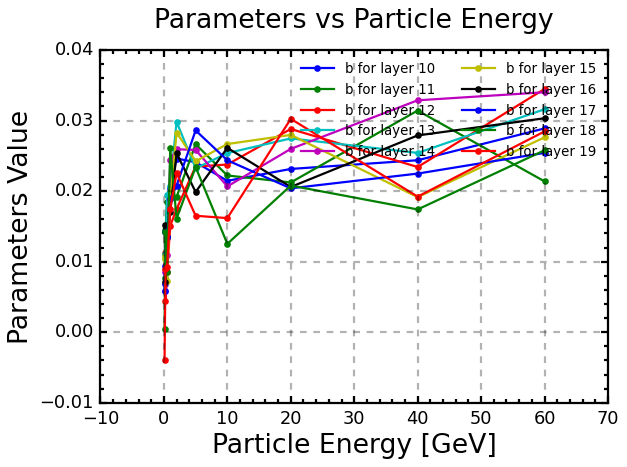

Fitted params for b for layer 20: a=1.0476, b=0.0000, c=-1.0300
Fitted params for b for layer 21: a=7.8529, b=0.0000, c=-7.8377
Fitted params for b for layer 22: a=2.6416, b=-0.0000, c=-2.6231
Fitted params for b for layer 23: a=-17.8444, b=0.0000, c=17.8631
Fitted params for b for layer 24: a=39.3306, b=-0.0000, c=-39.3057
Fitted params for b for layer 25: a=33.5967, b=-0.0000, c=-33.5866
Fit failed for b for layer 26
Fitted params for b for layer 27: a=-98.4651, b=0.0000, c=98.4945
Fitted params for b for layer 28: a=-43.2843, b=0.0000, c=43.3091
Fitted params for b for layer 29: a=35.8555, b=-0.0000, c=-35.8311


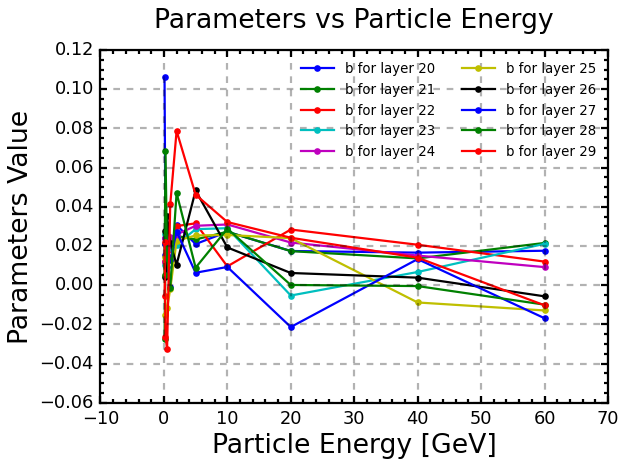

In [40]:
#normal method
Reco_hist = []
Reco_hist_cheat = []
coeffs_all = []
energies_all = []

def ConstructX(E_data, N_data,E_sum_calib,N_sum_calib):
    E_sum = np.sum(E_data, axis=1) + 1e-6  # shape: (Nsample,)
    N_sum = np.sum(N_data, axis=1) + 1e-6  # shape: (Nsample,)
    E_norm = E_data / E_sum[:, None]       # shape: (Nsample, Nlayer)
    N_norm = N_data / N_sum[:, None]       # shape: (Nsample, Nlayer)
    # E_sum_col = E_sum[:, None]
    # N_sum_col = N_sum[:, None]
    # E_exp = np.log(E_data + 1e-6)
    # N_exp = np.log(N_data + 1e-6)
    #X = np.hstack([E_data * np.exp(E_data), N_data])
    #X = np.hstack([E_sum_calib[:, np.newaxis],N_sum_calib[:, np.newaxis]])
    X = np.hstack([E_data, N_data])
    return X
def ConstructY(E_data, N_data,E_truth):
    E_sum = np.sum(E_data,axis=1)
    E_sum_calib = E_fit_line(E_sum)
    y = E_truth #bad idea
    return y
def ConstructModel(E_data,N_data,E_sum_calib,N_sum_calib,E_truth):
    X = ConstructX(E_data, N_data, E_sum_calib,N_sum_calib)
    y = ConstructY(E_data, N_data, E_truth)
    coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    E_reco = X @ coeffs
    return coeffs
def ReconstructE(E_data,N_data,E_sum_calib,N_sum_calib,coeffs):
    E_sum = np.sum(E_data,axis=1)
    E_sum_calib = E_fit_line(E_sum)
    X = ConstructX(E_data, N_data, E_sum_calib,N_sum_calib)
    y = X @ coeffs
    return y
def ConstructHists(E_reco):
    Nbins = 50
    mean = np.mean(E_reco)
    rms = np.std(E_reco)
    mask = (E_reco >= mean - 5*rms) & (E_reco <= mean + 5*rms)
    filtered_data = E_reco[mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    return counts, bin_edges

#Train
#E_data=np.hstack([E_layers_validate,E_sum_val_calib[:,np.newaxis]])
#N_data=np.hstack([N_layers_validate,N_sum_val_calib[:,np.newaxis]])
E_data = E_layers_validate
N_data = N_layers_validate
E_truth=E_truth_validate
E_Set=Energy_Val
coeffs=ConstructModel(E_data,N_data,E_sum_val_calib,N_sum_val_calib,E_truth)
#coeffs_all.append(coeffs)
#energies_all.append(-10)
for i_E, E_particle in enumerate(E_Set):
    mask = (E_truth == E_particle)
    E_reco = ReconstructE(E_data[mask], N_data[mask], E_sum_val_calib[mask], N_sum_val_calib[mask], coeffs)
    counts, bin_edges = ConstructHists(E_reco)
    Reco_hist.append({
        "E_truth": E_particle,
        "counts": counts,
        "bin_edges": bin_edges
    })
#cheat method
#E_data=np.hstack([E_layers_validate,E_sum_val_calib[:,np.newaxis]])
#N_data=np.hstack([N_layers_validate,N_sum_val_calib[:,np.newaxis]])
E_data = E_layers_validate
N_data = N_layers_validate
E_truth=E_truth_validate
E_Set=Energy_Val
for i_E, E_particle in enumerate(E_Set):
    mask = (E_truth == E_particle)
    coeffs = ConstructModel(E_data[mask], N_data[mask], E_sum_val_calib[mask], N_sum_val_calib[mask], E_truth[mask])
    coeffs_all.append(coeffs)
    energies_all.append(E_particle)
    E_reco_cheat = ReconstructE(E_data[mask], N_data[mask], E_sum_val_calib[mask], N_sum_val_calib[mask], coeffs)
    counts, bin_edges = ConstructHists(E_reco_cheat)
    if len(E_reco_cheat) == 0:
        continue  # 防止空集
    Reco_hist_cheat.append({
        "E_truth": E_particle,
        "counts": counts,
        "bin_edges": bin_edges
    })
coeffs_all = np.array(coeffs_all)  # shape: (n_energy, 60)


n_coeffs = coeffs_all.shape[1]  # 60
n_plots = 6
coeffs_per_plot = n_coeffs // n_plots  # 6
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 70)

for i in range(n_plots):
    plt.figure(figsize=(8,6))
    start = i * coeffs_per_plot
    end = (start + coeffs_per_plot) if i < n_plots-1 else n_coeffs
    for j in range(start, end):
        if j < 30:
            label = f'a for layer {j}'
        else:
            label = f'b for layer {j-30}'
        
        ydata = coeffs_all[:, j]
        plt.plot(energies_all, ydata, marker='o', linestyle='-', label=label)
        energies_all = np.array(energies_all)
        mask = (energies_all >= fit_range[0]) & (energies_all <= fit_range[1])
        x_fit = energies_all[mask]
        y_fit = ydata[mask]
        try:
            popt, _ = curve_fit(exp_func, x_fit, y_fit, p0=(1, 0.01, 0))
            print(f"Fitted params for {label}: a={popt[0]:.4f}, b={popt[1]:.4f}, c={popt[2]:.4f}")
        except RuntimeError:
            print(f"Fit failed for {label}")
    
    plt.xlabel("Particle Energy [GeV]")
    plt.ylabel("Parameters Value")
    plt.title(f"Parameters vs Particle Energy")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(ncol=2, fontsize=12)
    plt.tight_layout()
    plt.show()




In [41]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = max(bin_edges[0], mean - k*theta) # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-100, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


Mean: 0.09158313361930676, Peak: 0.08483876738048526, RMS: 0.025913011875165558
Initial Gamma Fit Parameters: [np.float64(21.76203232751342), np.float64(3.38004929096138), np.float64(0.0039958762039795925), np.float64(0.025913011875165558)]
Gamma Fit Parameters: [2.08854589e+01 1.30376557e+01 1.34685626e-02 5.82214201e-03]
Gamma Fit Peak: 0.08355350334886423 ± 0.000519844323689861, Resolution: 0.25160419813563634 ± 0.0056473635231059915


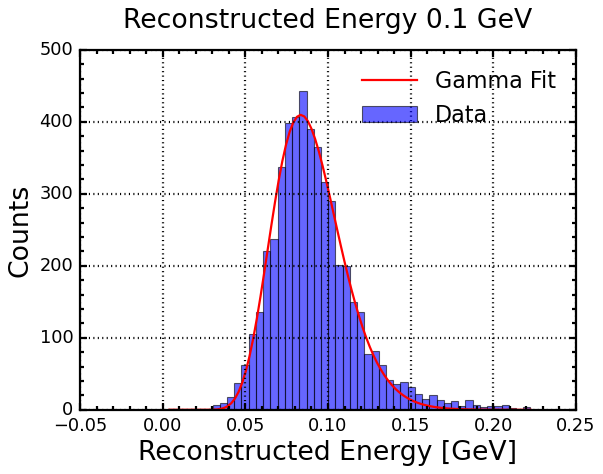

In [42]:
#This cell is left here for debug
i_E = 0  # Example index, change as needed
Hist = Reco_hist_cheat[i_E]
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all("E_reco",Hist["E_truth"],Hist["counts"],Hist["bin_edges"])





Mean: 0.09158313361930676, Peak: 0.08483876738048526, RMS: 0.025913011875165558
Initial Gamma Fit Parameters: [np.float64(21.76203232751342), np.float64(3.38004929096138), np.float64(0.0039958762039795925), np.float64(0.025913011875165558)]
Gamma Fit Parameters: [2.08854589e+01 1.30376557e+01 1.34685626e-02 5.82214201e-03]
Gamma Fit Peak: 0.08355350334886423 ± 0.000519844323689861, Resolution: 0.25160419813563634 ± 0.0056473635231059915


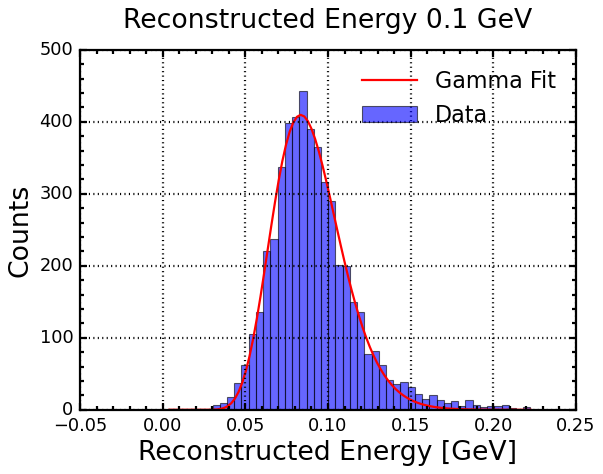

Mean: 0.23824248552590185, Peak: 0.21531299093244663, RMS: 0.050850452817288734
Initial Gamma Fit Parameters: [np.float64(40.36482571040966), np.float64(3.2336543873685484), np.float64(0.07380969567359877), np.float64(0.050850452817288734)]
Gamma Fit Parameters: [3.98454646e+01 9.01456086e+00 9.19661110e-02 1.61608505e-02]
Gamma Fit Peak: 0.22148823096110185 ± 0.0009909769752555224, Resolution: 0.21907148186626837 ± 0.0042850890978732


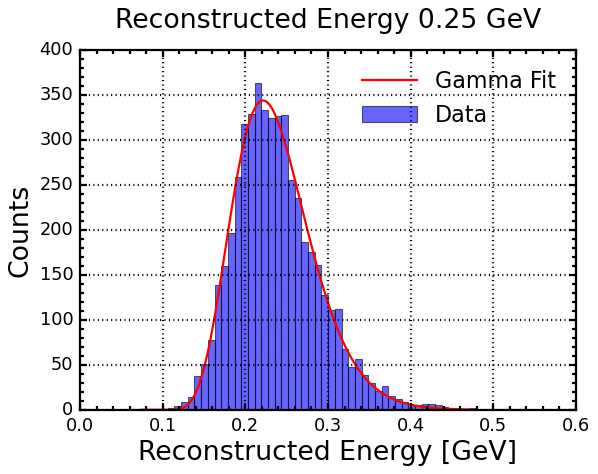

Mean: 0.48415297773687327, Peak: 0.4763222674927959, RMS: 0.08689807242695823
Initial Gamma Fit Parameters: [np.float64(78.811702307774), np.float64(4.535029275843393), np.float64(0.0900676752662582), np.float64(0.08689807242695823)]
Gamma Fit Parameters: [7.81833422e+01 1.98365240e+01 1.14077416e-01 1.85840541e-02]
Gamma Fit Peak: 0.464136397935518 ± 0.0016275295137119926, Resolution: 0.17833131848940387 ± 0.0028412813763247563


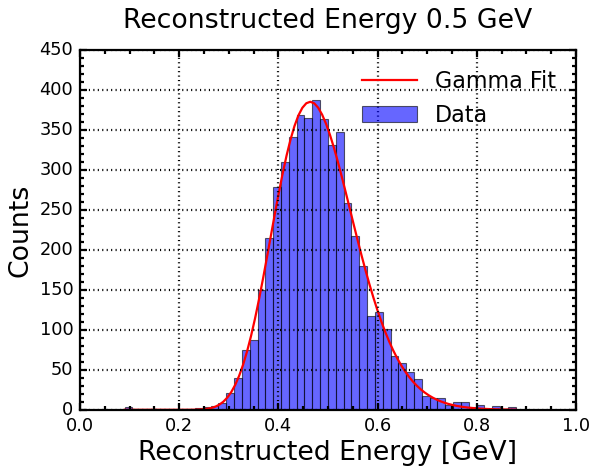

Mean: 0.9796947159094732, Peak: 0.9456158932961775, RMS: 0.14132693412204278
Initial Gamma Fit Parameters: [np.float64(118.32924518505511), np.float64(4.008863770134507), np.float64(0.4131342899634297), np.float64(0.14132693412204278)]
Gamma Fit Parameters: [1.18359643e+02 2.89562421e+01 2.19634074e-01 2.62605618e-02]
Gamma Fit Peak: 0.9537806988569658 ± 0.00356621436735275, Resolution: 0.14815850373636538 ± 0.002837207225517426


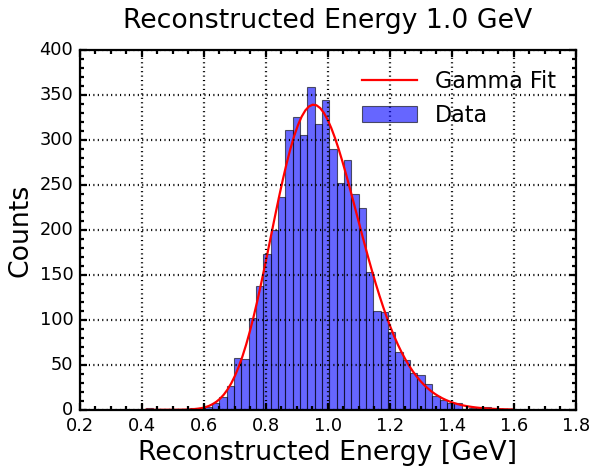

Mean: 1.9768348673553333, Peak: 1.9033473703427175, RMS: 0.21335070352164245
Initial Gamma Fit Parameters: [np.float64(171.47539904007746), np.float64(4.121954406453463), np.float64(1.097412994854353), np.float64(0.21335070352164245)]
Gamma Fit Parameters: [1.71367272e+02 4.12195441e+01 6.11917203e-01 3.32257483e-02]
Gamma Fit Peak: 1.948241652057702 ± 0.0046123065168067945, Resolution: 0.1094922900108038 ± 0.0016995907808808228


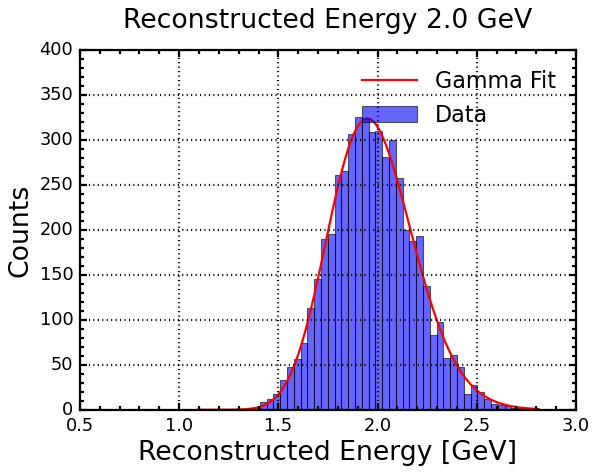

Mean: 4.973553622323868, Peak: 4.965139418644158, RMS: 0.3612574765902645
Initial Gamma Fit Parameters: [np.float64(294.4971405744431), np.float64(3.366280547258202), np.float64(3.757459606326475), np.float64(0.3612574765902645)]
Gamma Fit Parameters: [2.96526204e+02 3.36628055e+01 2.83257243e+00 6.41081385e-02]
Gamma Fit Peak: 4.926524087215723 ± 0.006499895675348468, Resolution: 0.07550013173000501 ± 0.0009483325557555729


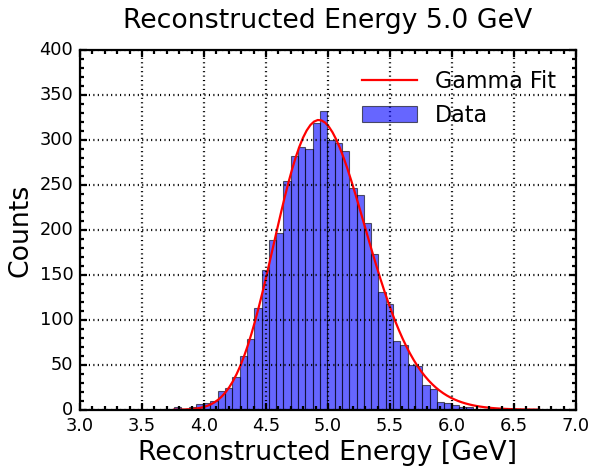

Mean: 9.97178291452777, Peak: 10.020476696909641, RMS: 0.52884639272677
Initial Gamma Fit Parameters: [np.float64(459.88574089824243), np.float64(4.865645962129326), np.float64(7.398603599170102), np.float64(0.52884639272677)]
Gamma Fit Parameters: [4.58335440e+02 4.86564596e+01 6.35577824e+00 7.50277436e-02]
Gamma Fit Peak: 9.931334879936246 ± 0.009608458412883809, Resolution: 0.05269683258709162 ± 0.0006678876355395723


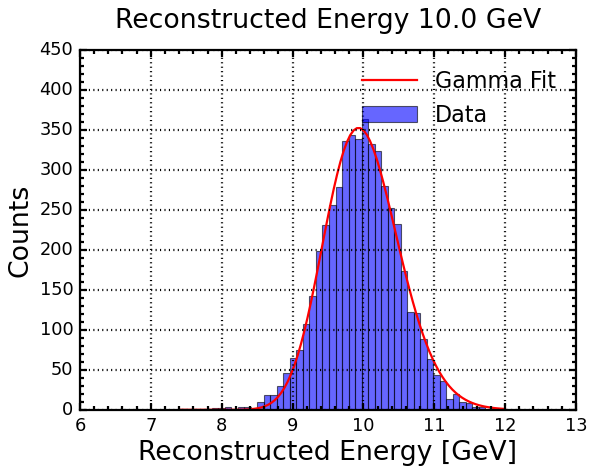

Mean: 19.973139005405724, Peak: 20.00975684911994, RMS: 0.7769113637614204
Initial Gamma Fit Parameters: [np.float64(623.8784743974684), np.float64(3.2479018569924665), np.float64(17.449807144326456), np.float64(0.7769113637614204)]
Gamma Fit Parameters: [6.22934736e+02 3.24790186e+01 1.55781952e+01 1.37091129e-01]
Gamma Fit Peak: 19.893689365466646 ± 0.019237231688291914, Resolution: 0.03927312586382636 ± 0.0006860983006372278


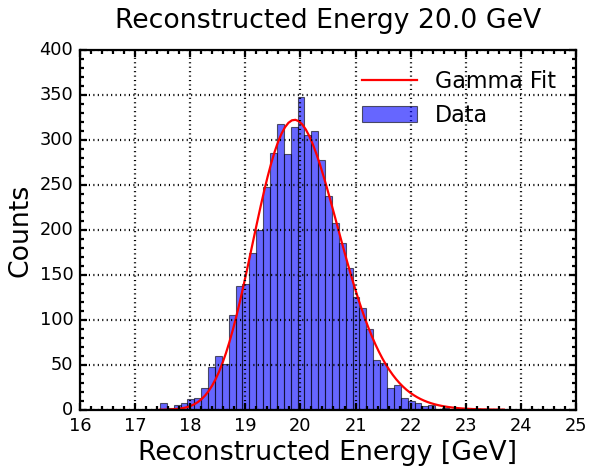

Mean: 39.9735652156642, Peak: 39.941521298918715, RMS: 1.1313823034366242
Initial Gamma Fit Parameters: [np.float64(1024.5030595774642), np.float64(5.011739724961731), np.float64(34.303371581412165), np.float64(1.1313823034366242)]
Gamma Fit Parameters: [1.02666230e+03 5.01173972e+01 3.19999109e+01 1.60618810e-01]
Gamma Fit Peak: 39.88908878611487 ± 0.021817099677960205, Resolution: 0.028506017138217352 ± 0.0003732860820204081


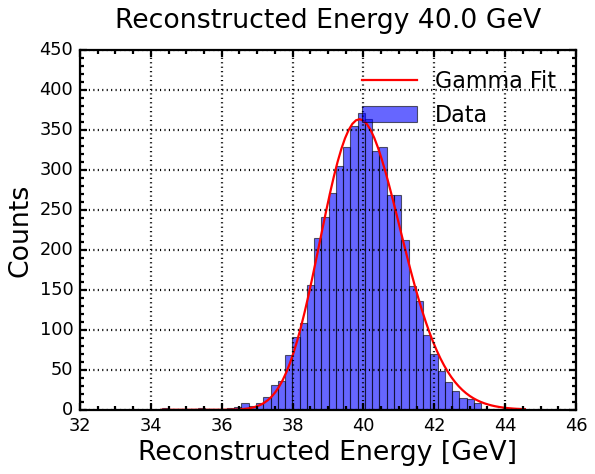

Mean: 59.970023227509046, Peak: 60.10281471533151, RMS: 1.3940673003942365
Initial Gamma Fit Parameters: [np.float64(1109.4086611943276), np.float64(3.646535386953998), np.float64(54.88650748482603), np.float64(1.3940673003942365)]
Gamma Fit Parameters: [1.10194423e+03 3.64653539e+01 5.17781448e+01 2.27522719e-01]
Gamma Fit Peak: 59.847318509783264 ± 0.03646365041281259, Resolution: 0.022957272493926272 ± 0.0004249836172196407


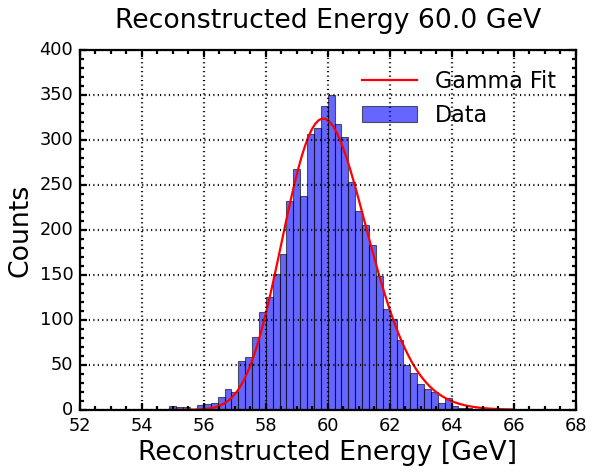

In [ ]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
results = []
CONF="cheat" #LW or cheat
for i_E in range(len(Energy_Val)):
    mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
    mean_log_normal,mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
    if CONF=="cheat":
        Hist = Reco_hist_cheat[i_E]
    elif CONF=="LW":
        Hist = Reco_hist[i_E]
    else:
        raise ValueError("Unknown CONF")
    mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Hist["E_truth"],Hist["counts"],Hist["bin_edges"])
    results.append({
        "ParticleEnergy": Energy_Val[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_{CONF}_Fit.csv")
df.to_csv(outputfile_name, index=False)

